# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [2]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [3]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

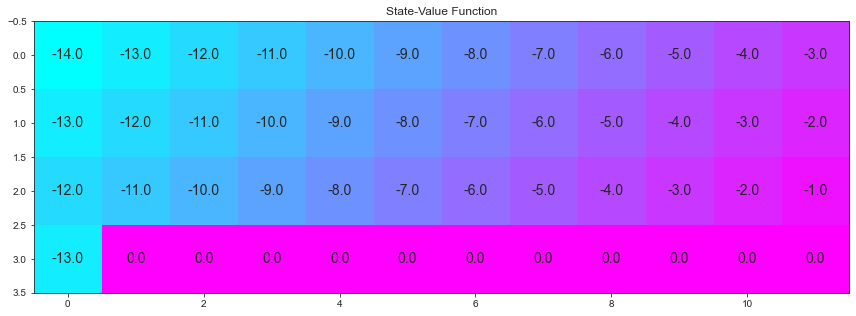

In [5]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [6]:
def decay_epsilon(eps_current, eps_decay, eps_min):
    eps_decayed = eps_current * eps_decay
    return eps_decayed if eps_decayed > eps_min else eps_min

In [7]:
def test_decay_epsilon():
    for eps_decay in [1, 0.5, 0.3, 0.1, 0.01]:
        eps_decayed = decay_epsilon(1.0, eps_decay, 0.1)
        print("eps_decayed(1.0, {eps_decay}, 0.1): {eps_decayed}".format(**locals()))

test_decay_epsilon()

eps_decayed(1.0, 1, 0.1): 1.0
eps_decayed(1.0, 0.5, 0.1): 0.5
eps_decayed(1.0, 0.3, 0.1): 0.3
eps_decayed(1.0, 0.1, 0.1): 0.1
eps_decayed(1.0, 0.01, 0.1): 0.1


In [8]:
def get_action_with_highest_reward(actions):
    # Initialize best_action and reward to the first index.
    best_action = 0
    reward = actions[0]
    for i in range(len(actions)):
        if actions[i] > reward:
            reward = actions[i]
            best_action = i
    return best_action

In [9]:
def test_get_action_with_highest_reward():
    stateActionDict = { 3: [-0.9, -1.0], 6: [-0.4, -0.2], 12: [1, 10], 16: [3, 8], 20: [10, 1]  }
    for i, key in enumerate(stateActionDict):
        best_action = get_action_with_highest_reward(stateActionDict[key])
        print("key: ", key, ", best action: ", best_action)

test_get_action_with_highest_reward()

key:  3 , best action:  0
key:  6 , best action:  1
key:  12 , best action:  1
key:  16 , best action:  1
key:  20 , best action:  0


In [10]:
def get_probabilities_epsilon_greedy(epsilon):
    # 1 - epsilon = action with highest rewards for the state
    # epsilon = random action
    # probability for random action will be 1 / numPossibleActions (which is 4 for cliff walking)
    
    # Return an array of 5 elements, in terms of probability of choosing the following actions:
    #   1. best current action
    #   2. UP (0)
    #   3. RIGHT (1)
    #   4. DOWN (2)
    #   5. LEFT (3)
    return [1.0 - epsilon, epsilon / 4, epsilon / 4, epsilon / 4, epsilon / 4]

In [11]:
def test_get_probabilities_epsilon_greedy():
    for epsilon in [1.0, 0.7, 0.3, 0.1]:
        print("epsilon: ", epsilon, ", probs: ", get_probabilities_epsilon_greedy(epsilon))

test_get_probabilities_epsilon_greedy()

epsilon:  1.0 , probs:  [0.0, 0.25, 0.25, 0.25, 0.25]
epsilon:  0.7 , probs:  [0.30000000000000004, 0.175, 0.175, 0.175, 0.175]
epsilon:  0.3 , probs:  [0.7, 0.075, 0.075, 0.075, 0.075]
epsilon:  0.1 , probs:  [0.9, 0.025, 0.025, 0.025, 0.025]


In [12]:
def choose_action_epsilon_greedy(Q, state, epsilon):
    probs = get_probabilities_epsilon_greedy(epsilon)

    # Get current best action for the state
    best_action = get_action_with_highest_reward(Q[state])

    # Choose an action, based on epsilon probability
    action = np.random.choice(np.array([best_action, 0, 1, 2, 3]), p=probs)
    
    return action

In [27]:
def generate_episode_sarsa(env, epsilon, Q, alpha, gamma):
    episode = []
    state = env.reset()
    while True:
        action = choose_action_epsilon_greedy(Q, state, epsilon)
        next_state, reward, done, info = env.step(action)
        
        #print("state: ", state, ", existing_q_value: ", Q[state][action], ", action: ", action, ", reward: ", reward, ", done: ", done, ", next_state: ", next_state)
        expected_next_reward = 0.0
        if not done:
            # Choose our next hypothetical action, based on epsilon-greedy Q-value for next_state.
            expected_next_action = choose_action_epsilon_greedy(Q, next_state, epsilon)
            # Calculate the Q-value 
            expected_next_reward = Q[next_state][eps_greedy_next_action]
        
        # Update our Q Table for this particular state and action.
        new_q_value = Q[state][action] + alpha * (reward + (gamma * expected_next_reward) - Q[state][action])

        # Update Q value
        Q[state][action] = new_q_value
        #print("state: ", state, ", new_q_value: ", new_q_value)

        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
            
    return episode

In [28]:
def sarsa(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes
    
    # Initialize epsilon
    epsilon = eps_start
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
#    if i_episode % 100 == 0:
        print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
        sys.stdout.flush()   
        
        ## TODO: complete the function
        
        # Decay epsilon
        if i_episode > 1:
            epsilon = decay_epsilon(epsilon, eps_decay, eps_min)

        # Generate episode
        episode = generate_episode_sarsa(env, epsilon, Q, alpha, gamma)
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 100/100

**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  0]
 [ 0  0  1  1  1  1  1  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


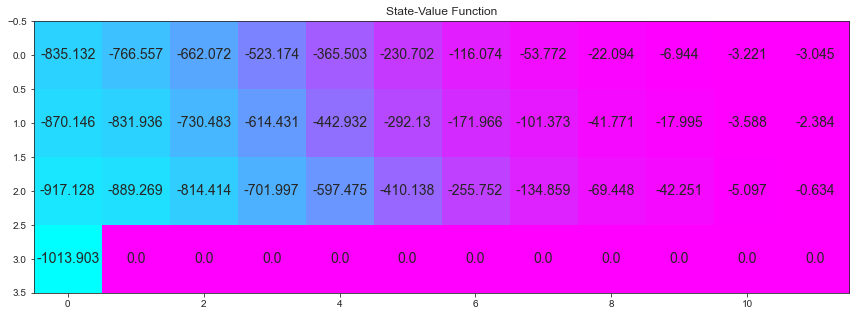

In [29]:
# obtain the estimated optimal policy and corresponding action-value function
#Q_sarsa = sarsa(env, 5000, .01)
Q_sarsa = sarsa(env, 100, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [ ]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])